In [1]:
import os
import shutil
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.utils import plot_model
from tensorflow.data.experimental import cardinality
from tensorflow_hub import KerasLayer
import tensorflow_text as text
from official.nlp import optimization  
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset = tf.keras.utils.get_file('aclImdb_v1', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84131840/84125825 [==============================] - 3s 0us/step


In [2]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [33]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(2):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'I try to be very objective when I view a low budget movie. I also apply a lower weight to independent and low budget productions versus the big budget productions. I expect near flawlessness from big budget productions and their studios. Therefore I apply tougher criteria to the major studio releases. But this movie was just a dud. Period. The premise was terrible. The main character, Mary Gordano (Alicia Silverstone), was unbelievable as a high school senior with an unquenchable desire to solve crimes. There was not enough depth in her character or her acting that pulled you into her world. Also, to make this movie more mysterious, the lighting in certain scenes did not set the mood, especially in the warehouse.<br /><br />Once again another disappointing movie that I could only give three points to.'
Label : 0 (neg)
Review: b'Have you ever, or do you have, a pet who\'s been with you through thick and thin, who you\'d be lost without, and who you love no matter what? Betcha 

In [4]:
preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [5]:
def build_model():
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = KerasLayer(preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = KerasLayer(bert_encoder, trainable=True, name='BERT')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation=None, name='classifier')(net)
    return Model(text_input, net)

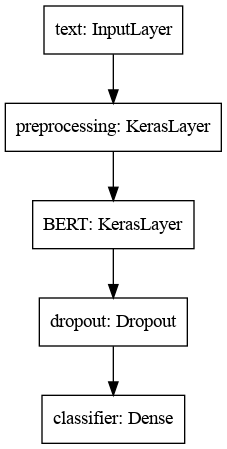

In [6]:
model = build_model()
plot_model(model, to_file='Images/model.png')

In [7]:
loss = BinaryCrossentropy(from_logits=True)
metrics = BinaryAccuracy()

In [34]:
# AdamW optimizer with same scheduling 
# as the original BERT pre-training
epochs = 5
steps_per_epoch = cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [9]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/5
625/625 [==============================] - 163s 248ms/step - loss: 0.5772 - binary_accuracy: 0.6598 - val_loss: 0.3940 - val_binary_accuracy: 0.8346
Epoch 2/5
625/625 [==============================] - 155s 248ms/step - loss: 0.3667 - binary_accuracy: 0.8318 - val_loss: 0.3697 - val_binary_accuracy: 0.8410
Epoch 3/5
625/625 [==============================] - 153s 245ms/step - loss: 0.2777 - binary_accuracy: 0.8808 - val_loss: 0.4003 - val_binary_accuracy: 0.8450
Epoch 4/5
625/625 [==============================] - 152s 243ms/step - loss: 0.2093 - binary_accuracy: 0.9146 - val_loss: 0.4337 - val_binary_accuracy: 0.8480
Epoch 5/5
625/625 [==============================] - 153s 244ms/step - loss: 0.1658 - binary_accuracy: 0.9370 - val_loss: 0.4901 - val_binary_accuracy: 0.8494


In [13]:
loss, accuracy = model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 83s 106ms/step - loss: 0.4578 - binary_accuracy: 0.8568
Loss: 0.45777058601379395
Accuracy: 0.8567600250244141


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


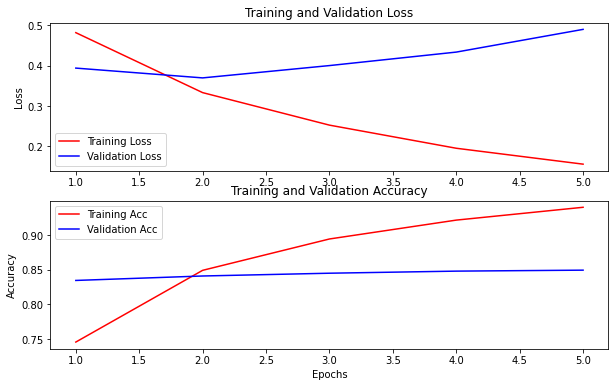

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label="Training Acc")
plt.plot(epochs, val_acc, 'b', label="Validation Acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="Lower Right")

In [11]:
## Save the model for inference
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
model.save(saved_model_path, include_optimizer=False)

In [12]:
# Reload the saved model
model = tf.saved_model.load(saved_model_path)